In [6]:
def runPheromones(MAX_ITERATION, ADJENCYMATRX, ant_population, start_node, evaporation_probability, constant_Q, alpha, beta, bestvalue): # will return average Line among all ants and the best search
    city_size = len(ADJENCYMATRX)
    PHEROMONESLIST = generatePheromoneMatrix(city_size)
    average_weight_history = []
    best_weight_history = []
    best_weight = 9223372036854775807
    bestvalue_foundat = MAX_ITERATION
    found_bestweight = False

    for iteration in range(MAX_ITERATION):
        #print2d(PHEROMONESLIST)
        ANTS = []
        for i in range(ant_population):
            local_ant = Ant(start_node, city_size)
            ANTS.append(local_ant)

        for ant in ANTS:
            while(not ant.isDone()):
                nextnode = ant.getNextNode(PHEROMONESLIST, ADJENCYMATRX, alpha, beta)
                ant.visit(nextnode)

        #all ants are done so we check their path and mutate the prob

        evaporatePheromone(PHEROMONESLIST, evaporation_probability)



        for ant in ANTS:
            ant.visitedList.append(start_node)


        SORTED_ANTS = sorted(ANTS, key=lambda ant: readWeight(ant.visitedList , ADJENCYMATRX))
        count = 0
        #for ant in ANTS:
        for ant in SORTED_ANTS:
            if count ==10:
                break

            currentpath = ant.visitedList
            distance_travelled = readWeight(currentpath, ADJENCYMATRX)
            #print(currentpath)
            for i in range(len(currentpath)-1):

              from_index = currentpath[i]
              to_index = currentpath[i+1]
              PHEROMONESLIST[from_index][to_index] += constant_Q/distance_travelled
              PHEROMONESLIST[to_index][from_index] += constant_Q/distance_travelled

            count = count +1



        sum_total = 0
        for ant in ANTS:
            currentweight = readWeight(ant.visitedList, ADJENCYMATRX)
            if currentweight == bestvalue and found_bestweight == False:
               bestvalue_foundat = iteration
               found_bestweight = True

            if (currentweight < best_weight):
                best_weight = currentweight
            sum_total += currentweight

        average_weight_history.append(sum_total/ ant_population)
        best_weight_history.append(best_weight)



    return (average_weight_history, best_weight_history, bestvalue_foundat)





def runTSP(trial, iteration, data_set, ant_numbers, startnode, evapooration_prob, Q, alpha, beta, bestvalue):
    import statistics
    best_absolute_history = []
    avg_best_best_history = []
    best_found_iteration_history = []
    sd_list=[]

    for i in range(trial):
        random.seed(i)
        (avg, best, iter) = runPheromones(iteration, data_set, ant_numbers, startnode, evapooration_prob, Q, alpha, beta, bestvalue)
        best_absolute_history.append(best)
        avg_best_best_history.append(avg)
        best_found_iteration_history.append(iter)

    print(f"Setting: {ant_numbers} ants, alpha = {alpha}, beta = {beta}, constant_Q ={Q}, evaporation_probability = {evapooration_prob}")


    best_max = 999999999
    avg_max = 0
    avg_best = 0


    for i in range(trial):
        sd_list.append(avg_best_best_history[i][iteration-1])
        avg_max += avg_best_best_history[i][iteration-1]
        avg_best += best_found_iteration_history[i]

        if best_absolute_history[i][iteration-1] < best_max:
            best_max = best_absolute_history[i][iteration-1]

    standard_deviation = statistics.stdev(sd_list)
    print(f"best_max: {best_max}, avg_max: {avg_max/ trial}, best_iteration: {avg_best/ trial}, sd: {standard_deviation}")

    return (best_absolute_history, avg_best_best_history)



import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plotcborn(trial, iteration, data_set, ant_pop, start_node, evap_prob, Q, alpha,beta, color1, color2, best_sol):
    (best_absolute_history, avg_best_best_history) = runTSP(trial, iteration, data_set, ant_pop, start_node, evap_prob, Q, alpha,beta, best_sol)

    # Example data (replace this with your actual list of lists)
    list_of_lists = avg_best_best_history

    # Calculate average, best, and worst for each iteration
    avg_values = np.mean(list_of_lists, axis=0)
    best_values = np.max(list_of_lists, axis=0)
    worst_values = np.min(list_of_lists, axis=0)

    # Create a DataFrame for plotting
    data = {
        'Iteration': list(range(len(avg_values))),
        'Average_Distance_travelled': avg_values,
        'Best': best_values,
        'Worst': worst_values
    }
    df = pd.DataFrame(data)

    # Use Seaborn to plot the lines with a shaded confidence interval representing the range
    label_ant = 'Averagebest among' + str(ant_pop) + 'ants'
    sns.lineplot(x='Iteration', y='Average_Distance_travelled', data=df, color= color1, label = label_ant)
    plt.fill_between(df['Iteration'], df['Best'], df['Worst'], alpha=0.3, color= color1, label='Best-Worst Range of Averagebest')
    plt.legend(loc='best')

    list_of_lists = best_absolute_history
    # Calculate average, best, and worst for each iteration
    avg_values = np.mean(list_of_lists, axis=0)
    best_values = np.max(list_of_lists, axis=0)
    worst_values = np.min(list_of_lists, axis=0)

    # Create a DataFrame for plotting
    data = {
        'Iteration': list(range(len(avg_values))),
        'Average_Distance_travelled': avg_values,
        'Best': best_values,
        'Worst': worst_values
    }
    df = pd.DataFrame(data)

    # Use Seaborn to plot the lines with a shaded confidence interval representing the range
    label_ant = 'The best of best among' + str(ant_pop) + 'ants'
    sns.lineplot(x='Iteration', y='Average_Distance_travelled', data=df, color= color2, label = label_ant)
    plt.fill_between(df['Iteration'], df['Best'], df['Worst'], alpha=0.3, color= color2, label='Best-Worst Range of Bestbest')
    plt.legend(loc='best')
    plt.show()




In [7]:
import random
class Ant():

    def __init__(self, start_node, citysize):
        self.citysize = citysize
        self.start_node = start_node
        self.visited = set()
        self.visitedList = list()
        self.current_node = start_node

        self.visited.add(start_node)
        self.visitedList.append(start_node)


    def visit(self, next_node):
        self.visited.add(next_node)
        self.visitedList.append(next_node)
        self.current_node = next_node

    def isDone(self):
        if len(self.visited) < self.citysize:
            return False
        else:
            return True
    def getNextNode(self, pheromoneMatrix, AdjencyMatrix, alpha, beta):
        Next_index = []
        Pheromones_list = []
        currentnode = self.current_node
        for i in range(len(pheromoneMatrix)):
            if i in self.visited:
                continue

            nextnode_pheromone = pheromoneMatrix[currentnode][i]
            Next_index.append(i)
            Pheromones_list.append(nextnode_pheromone)

        Probability_list  = []


        for i in range(len(Next_index)):
            real_edge =  Next_index[i]
            real_edge_value = AdjencyMatrix[self.current_node][real_edge]

            offsetfromlegth = 1/real_edge_value
            pheromonevalue = Pheromones_list[i]

            Probability_list.append((offsetfromlegth ** alpha) * (pheromonevalue ** beta))


        Running_List = []
        sum = 0
        for i in range(len(Next_index)):
            sum+= Probability_list[i]
            Running_List.append(sum)

        roulette_val = random.random() * Running_List[len(Running_List)-1]

        for i in  range(len(Running_List)):
            if roulette_val <= Running_List[i]:
                return Next_index[i]


def generatePheromoneMatrix(citysize):
    return [[1 for _ in range(citysize)] for _ in range(citysize)]

def evaporatePheromone(pheromoneMatrix, evaporation_rate):
    for from_node in range(len(pheromoneMatrix)):
        for to_node in range(len(pheromoneMatrix)):
            pheromoneMatrix[from_node][to_node] = pheromoneMatrix[from_node][to_node] * (1-evaporation_rate)

def getRunningMatrix(pheromoneMatrix):
    Res_arr = []
    total = 0
    for from_node in range(len(pheromoneMatrix)):
        Inner_arr = []
        for to_node in range(len(pheromoneMatrix)):
            if from_node == to_node:
                Inner_arr.append(total)
            else:
                total += pheromoneMatrix[from_node][to_node]
                Inner_arr.append(total)
        Res_arr.append(Inner_arr)
    return Res_arr


def readWeight(Traversalorder, Adjencymatrix):
    weight = 0
    for i in range(len(Traversalorder)-1):
        current = Traversalorder[i]
        currentplus1 = Traversalorder[i+1]
        weight += Adjencymatrix[current][currentplus1]
    return weight




In [8]:
def readfile(file):
    filename = file
    f = open(filename,'r')
    Res_arr = []


    for line in f:
        Row_arr = []
        temp = line.split()
        for i in temp:
            Row_arr.append(int(i))
        Res_arr.append(Row_arr)
    return Res_arr

First_data_set = [[0, 633, 257,  91 ,412 ,150 , 80 ,134 ,259, 505 ,353 ,324 , 70 ,211 ,268 ,246, 121],
                [633 ,  0 ,390 ,661 ,227, 488 ,572 ,530, 555, 289 ,282 ,638, 567, 466 ,420 ,745, 518],
                [257, 390,   0 ,228, 169 ,112, 196, 154, 372, 262, 110, 437, 191,  74 , 53, 472, 142],
                [91 ,661, 228 ,  0, 383 ,120 , 77 ,105, 175 ,476 ,324 ,240,  27, 182, 239 ,237,  84],
                [412 ,227 ,169 ,383  , 0, 267, 351, 309, 338, 196,  61 ,421, 346, 243, 199 ,528, 297],
                [150 ,488 ,112 ,120, 267 ,  0,  63,  34, 264, 360, 208 ,329 , 83, 105 ,123, 364 , 35],
                [80 ,572 ,196 , 77, 351,  63,   0 , 29, 232, 444, 292, 297 , 47, 150 ,207, 332 , 29],
                [134 ,530 ,154, 105, 309 , 34,  29,   0, 249, 402, 250 ,314 , 68, 108 ,165 ,349 , 36],
                [259 ,555 ,372, 175, 338, 264, 232, 249,   0, 495 ,352 , 95, 189, 326 ,383, 202, 236],
                [505 ,289 ,262, 476, 196,360, 444, 402, 495 ,  0, 154, 578 ,439, 336, 240,685, 390],
                [353 ,282 ,110 ,324 , 61, 208, 292, 250, 352, 154 ,  0 ,435 ,287, 184, 140, 542, 238],
                [324 ,638 ,437 ,240 ,421, 329, 297, 314,  95, 578, 435 , 0 ,254 ,391 ,448, 157 ,301],
                [ 70 ,567 ,191 , 27 ,346 , 83,  47,  68, 189, 439 ,287 ,254 ,  0 ,145, 202, 289,  55],
                [211 ,466  ,74, 182 ,243, 105, 150, 108 ,326 ,336 ,184 ,391, 145 ,  0,  57, 426 , 96],
                [268 ,420 , 53, 239 ,199, 123, 207, 165, 383 ,240 ,140 ,448 ,202 , 57 ,  0, 483, 153],
                [246 ,745 ,472, 237 ,528, 364, 332, 349, 202 ,685 ,542 ,157 ,289, 426,483 ,  0, 336],
                [121 ,518 ,142 , 84 ,297,  35,  29 , 36 ,236 ,390, 238 ,301 , 55 , 96 ,153 ,336 ,  0 ] ]

Sec_data_set = [
                [     0  ,83 , 93 ,129 ,133, 139 ,151 ,169, 135, 114, 110 , 98,  99 , 95,  81, 152, 159, 181 ,172, 185, 147 ,157 ,185 ,220, 127, 181],
                [ 83   ,0 , 40 , 53  ,62 , 64 , 91 ,116 , 93 , 84 , 95 , 98,  89 , 68,  67, 127, 156, 175, 152, 165 ,160, 180 ,223 ,268, 179 ,197],
                [93  ,40  , 0 , 42  ,42 , 49 , 59  ,81 , 54 , 44 , 58 , 64 , 54 , 31 , 36 , 86, 117, 135 ,112, 125 ,124, 147, 193, 241, 157, 161],
                [129  ,53 , 42 ,  0 , 11 , 11 , 46  ,72 , 65 , 70 , 88 ,100 , 89  ,66 , 76, 102 ,142, 156, 127 ,139 ,155, 180, 228 ,278 ,197, 190],
                [133  ,62 , 42 , 11  , 0  , 9 , 35  ,61 , 55 , 62 , 82 , 95 , 84 , 62 , 74  ,93 ,133 ,146 ,117, 128, 148, 173 ,222, 272, 194, 182],
                [139  ,64 , 49 , 11  , 9  , 0 , 39  ,65 , 63 , 71 , 90 ,103, 92 , 71,  82 ,100, 141, 153 ,124, 135, 156, 181 ,230 ,280, 202 ,190],
                [151  ,91 , 59 , 46 , 35 , 39  , 0  ,26 , 34 , 52,  71 , 88 , 77 , 63 , 78,  66 ,110 ,119,  88 , 98 ,130 ,156, 206, 257, 188, 160],
                [169 ,116 , 81 , 72 , 61 , 65 , 26  , 0 , 37 , 59 , 75 , 92 , 83 , 76 , 91 , 54 , 98, 103 , 70 , 78, 122, 148, 198, 250, 188, 148],
                [135  ,93 , 54 , 65 , 55 , 63 , 34 , 37 ,  0 , 22 , 39 , 56 , 47 , 40 , 55 , 37 , 78 , 91,  62,  74,  96 ,122 ,172, 223, 155, 128],
                [114  ,84 , 44  ,70 , 62 , 71 , 52 , 59 , 22 ,  0 , 20 , 36 , 26 , 20 , 34 , 43 , 74,  91 , 68,  82,  86, 111, 160, 210, 136, 121],
                [110  ,95 , 58 , 88 , 82 , 90 , 71 , 75 , 39,20 ,  0 , 18 , 11 , 27 , 32 , 42 , 61,  80 , 64 , 77,  68,  92 ,140 ,190 ,116, 103],
                [98  ,98 , 64 ,100 , 95, 103 , 88  ,92 , 56 , 36,  18,   0  ,11,  34 , 31,  56 , 63  ,85 , 75,  87 , 62,  83, 129 ,178, 100 , 99],
                [99  ,89 , 54  ,89 , 84 , 92 , 77,  83 , 47 , 26  ,11 , 11 ,  0,  23 , 24 , 53 , 68 , 89,  74 , 87 , 71  ,93 ,140, 189 ,111, 107],
                [95  ,68 , 31 , 66 , 62, 71 , 63 , 76 , 40 , 20 , 27,  34 , 23,   0 , 15,  62 , 87 ,106 , 87, 100 , 93 ,116 ,163, 212, 132 ,130],
                [81  ,67 , 36  ,76 , 74 , 82 , 78 , 91 , 55,  34 , 32,  31 , 24 , 15 ,  0 , 73 , 92, 112 , 96, 109  ,93, 113, 158, 205 ,122 ,130],
                [152 ,127 , 86 ,102 , 93 ,100 , 66 , 54 , 37 , 43 , 42 , 56 , 53 , 62 , 73 ,  0 , 44 , 54 , 26 , 39 , 68 , 94, 144, 196 ,139 , 95],
                [159 ,156 ,117 ,142 ,133, 141, 110 , 98 , 78 , 74 , 61,  63 , 68 , 87 , 92 , 44  , 0 , 22 , 34 , 38 , 30  ,53, 102, 154, 109 , 51],
                [181 ,175 ,135 ,156, 146, 153 ,119, 103 , 91 , 91,  80,  85 , 89, 106 ,112 , 54 , 22  , 0 , 33  ,29 , 46 , 64 ,107 ,157, 125,  51],
                [172 ,152 ,112 ,127, 117, 124 , 88 , 70 , 62 , 68 , 64,  75 , 74 , 87 , 96 , 26 , 34 , 33  , 0  ,13 , 63,  87, 135, 186, 141 , 81],
                [185, 165, 125 ,139, 128, 135 , 98 , 78 , 74 , 82,  77,  87 , 87 ,100, 109 , 39  ,38 , 29 , 13  , 0  ,68 , 90, 136 ,186, 148,  79],
                [147, 160, 124 ,155 ,148, 156 ,130, 122 , 96 , 86 , 68,  62 , 71,  93  ,93  ,68 , 30  ,46 , 63 , 68 ,  0 , 26 , 77 ,128 , 80  ,37],
                [157 ,180, 147, 180, 173, 181, 156, 148, 122 ,111 , 92 , 83 , 93, 116, 113 , 94  ,53 , 64,  87 , 90 , 26,   0 , 50 ,102 , 65,  27],
                [185 ,223, 193, 228, 222, 230 ,206,198, 172, 160 ,140, 129, 140, 163, 158, 144 ,102 ,107 ,135, 136 , 77 , 50  , 0 , 51 , 64 , 58],
                [220 ,268, 241, 278 ,272, 280, 257, 250,223, 210, 190 ,178 ,189 ,212, 205 ,196, 154 ,157, 186 ,186, 128, 102 , 51 ,  0 , 93, 107],
                [ 127 ,179, 157, 197, 194, 202, 188 ,188, 155 ,136 ,116 ,100,111, 132 ,122 ,139, 109, 125, 141 ,148 , 80 , 65 , 64 , 93  , 0 , 90],
                [ 181, 197, 161 ,190 ,182, 190, 160 ,148 ,128, 121 ,103,  99 ,107 ,130 ,130 , 95  ,51 , 51 , 81  ,79 , 37 , 27,  58, 107,  90  , 0]
]




Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 2094, avg_max: 2229.9, best_iteration: 500.0, sd: 58.04345014954881


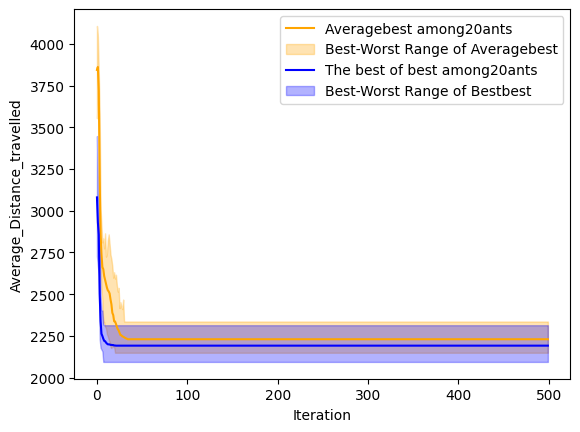

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 2085, avg_max: 2235.4, best_iteration: 475.5, sd: 76.48281540732911


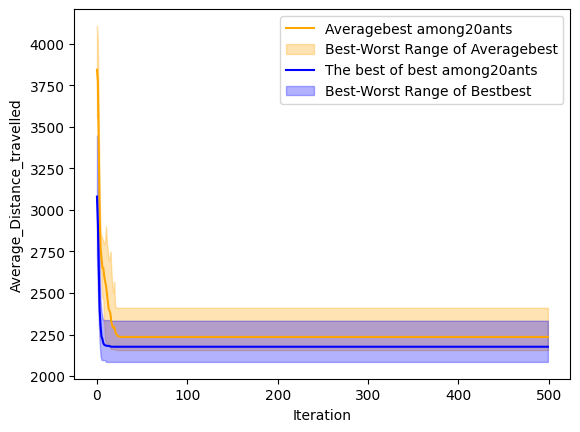

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 2104, avg_max: 2238.3, best_iteration: 500.0, sd: 66.08455508704459


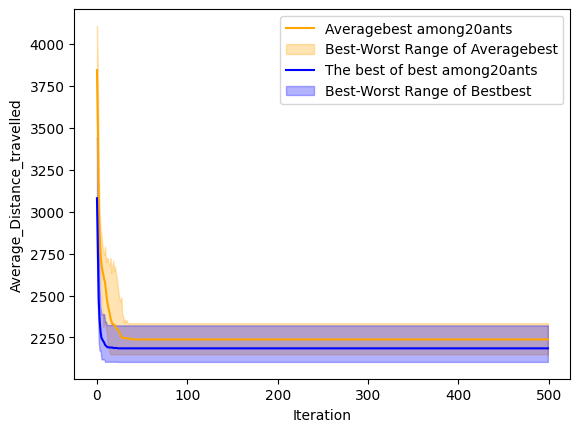

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 2088, avg_max: 2274.9, best_iteration: 500.0, sd: 95.85180447468181


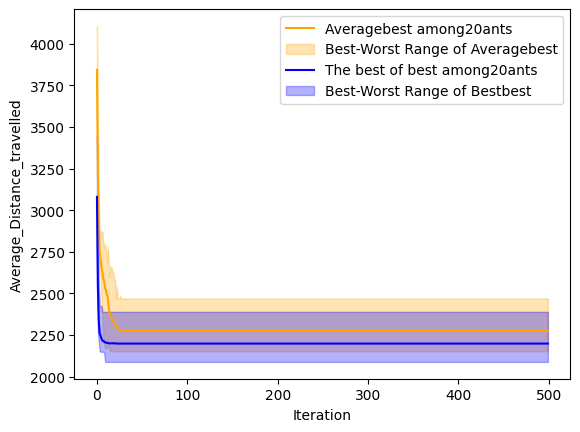

In [9]:
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1,1,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 10,1,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 100,1,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1000,1,1, 'orange', 'blue',2085)


Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 2085, avg_max: 2221.8, best_iteration: 427.5, sd: 60.689546485631105


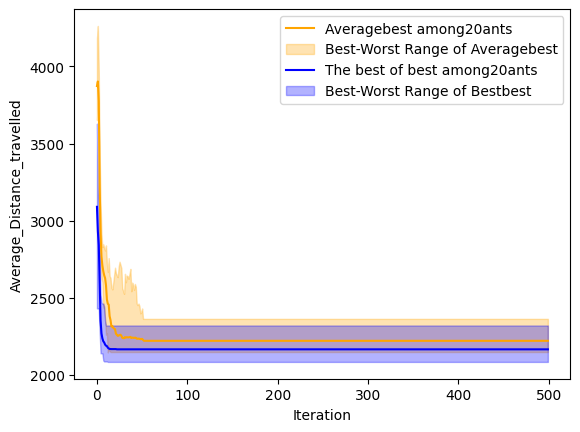

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 2088, avg_max: 2212.15, best_iteration: 500.0, sd: 71.16199088957826


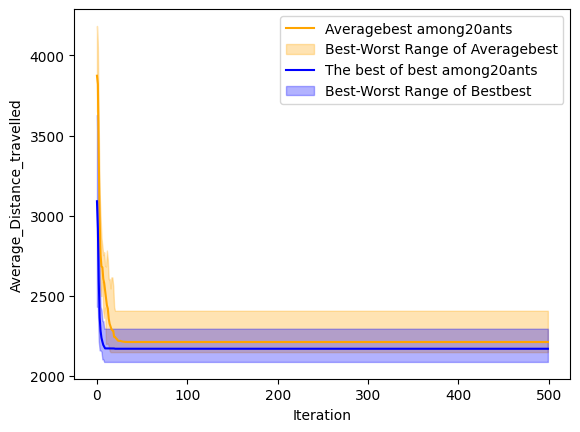

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 2119, avg_max: 2220.55, best_iteration: 500.0, sd: 70.52246749123736


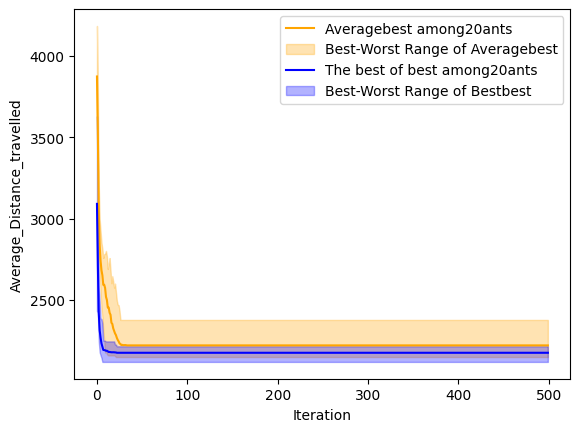

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 2088, avg_max: 2240.7, best_iteration: 500.0, sd: 77.6843139351758


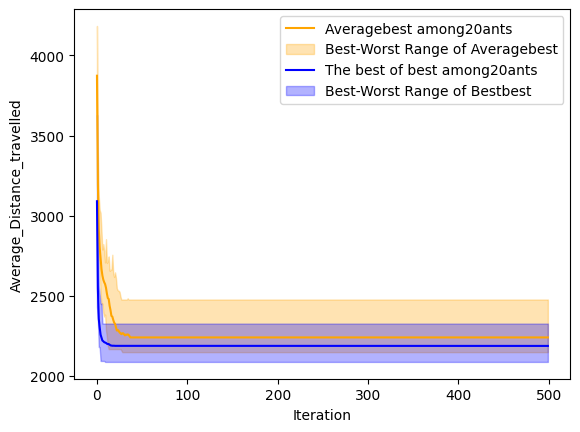

In [10]:
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1,.95,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 10,.95,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 100,.95,1, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1000,.95,1, 'orange', 'blue',2085)

# New Section

# New Section

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1, evaporation_probability = 0.95
best_max: 2088, avg_max: 2221.85, best_iteration: 500.0, sd: 67.40004294860415


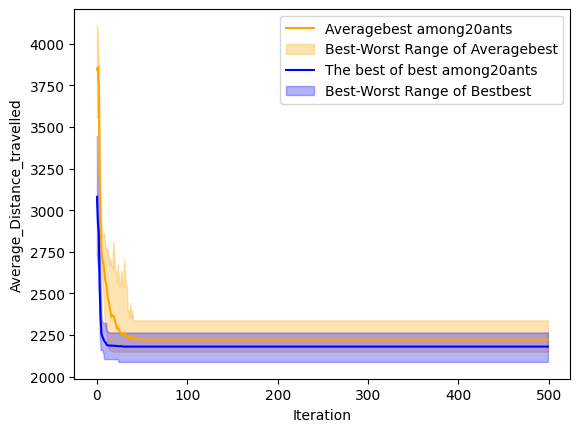

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =10, evaporation_probability = 0.95
best_max: 2085, avg_max: 2261.5, best_iteration: 475.25, sd: 75.14442235140487


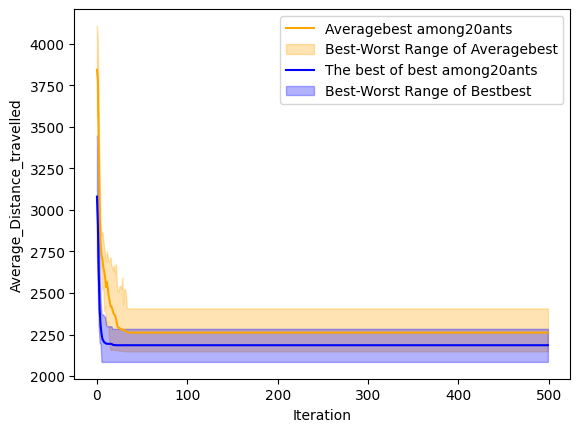

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =100, evaporation_probability = 0.95
best_max: 2097, avg_max: 2239.3, best_iteration: 500.0, sd: 84.18594707081773


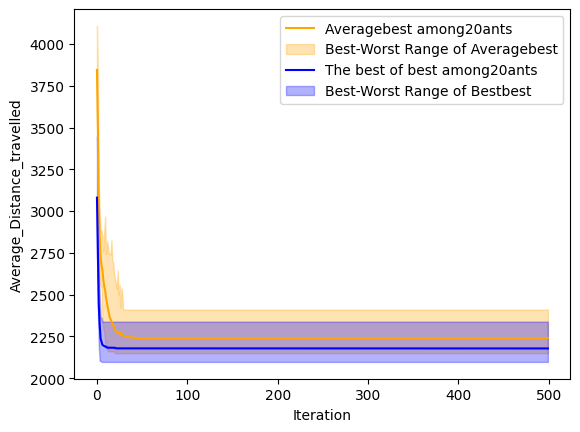

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1000, evaporation_probability = 0.95
best_max: 2110, avg_max: 2241.25, best_iteration: 500.0, sd: 69.7407794320473


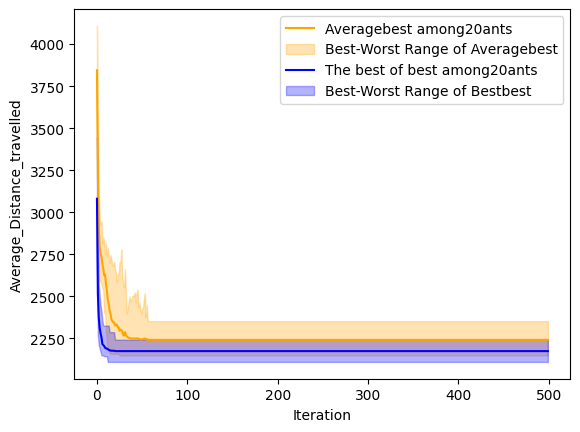

In [11]:
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1,1,.95, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 10,1,.95, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 100,1,.95, 'orange', 'blue', 2085)
plotcborn(20, 500, First_data_set, 20, 0 , 0.95, 1000,1,.95, 'orange', 'blue',2085)

The 3rd TSP


Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 35230, avg_max: 37480.3, best_iteration: 500.0, sd: 1370.880742634572


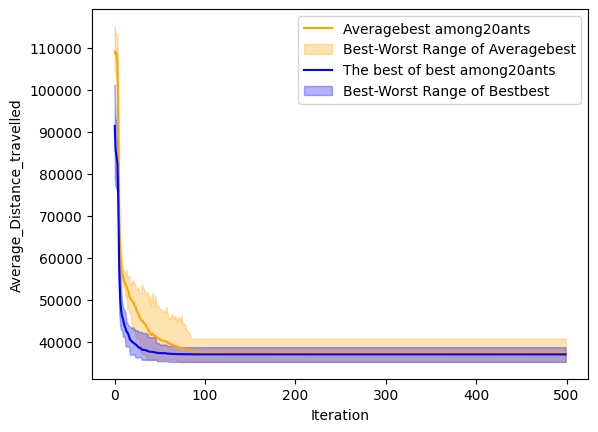

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 34679, avg_max: 37311.5, best_iteration: 500.0, sd: 1720.1331190836427


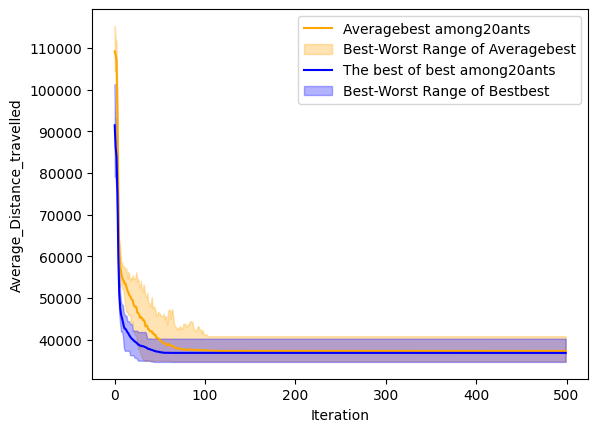

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 35000, avg_max: 37252.1, best_iteration: 500.0, sd: 907.2307720112951


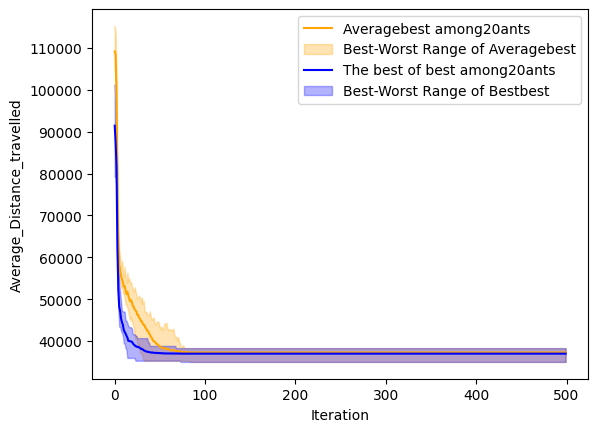

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 34747, avg_max: 37700.8, best_iteration: 500.0, sd: 1485.07230375104


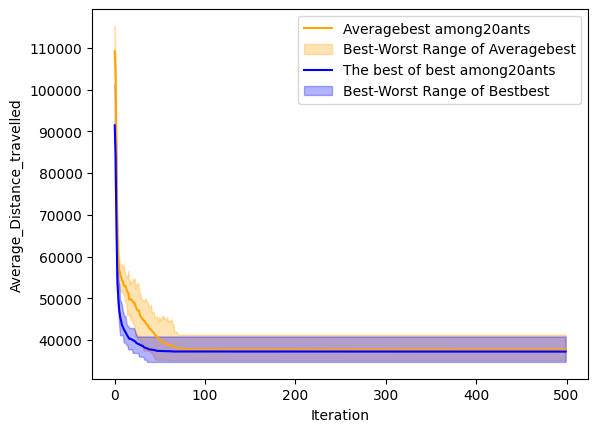

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 34512, avg_max: 37528.7, best_iteration: 500.0, sd: 1578.1415152340626


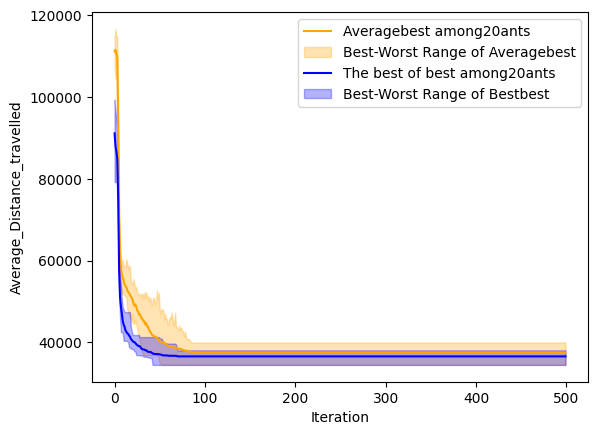

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 34397, avg_max: 37087.15, best_iteration: 500.0, sd: 1243.2658298546658


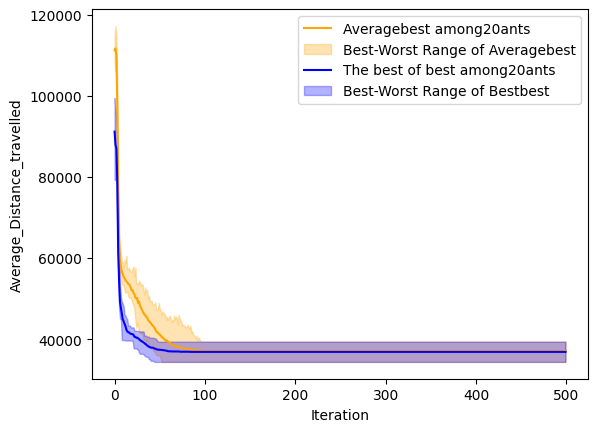

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 34930, avg_max: 37268.45, best_iteration: 500.0, sd: 1488.8668766265805


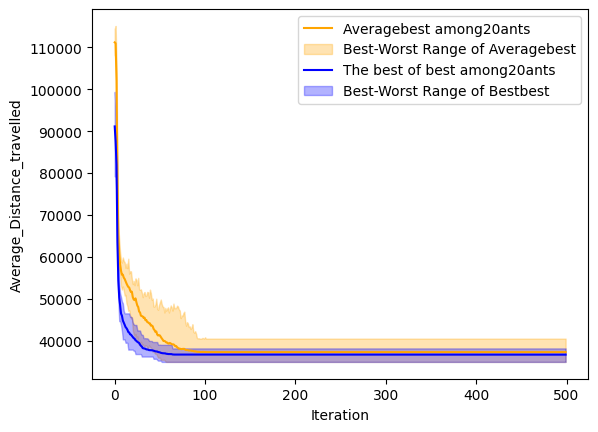

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 35410, avg_max: 37733.7, best_iteration: 500.0, sd: 1312.1389969696127


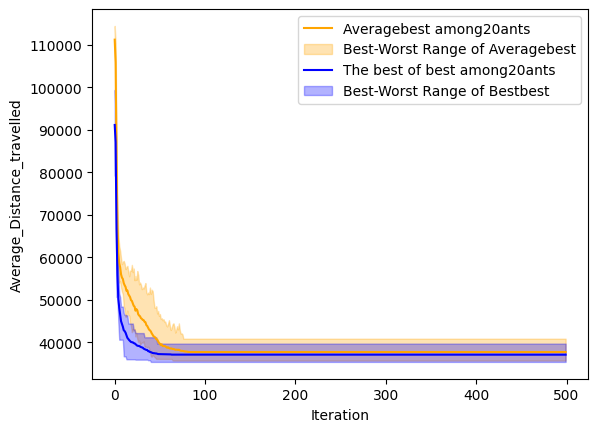

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1, evaporation_probability = 0.95
best_max: 34246, avg_max: 36876.3, best_iteration: 500.0, sd: 1316.0961850947872


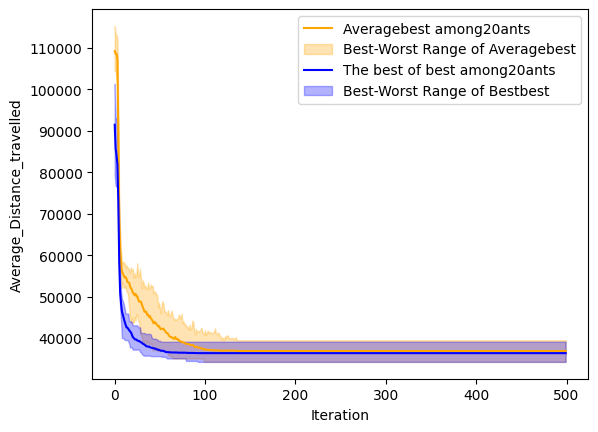

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =10, evaporation_probability = 0.95
best_max: 34081, avg_max: 36931.25, best_iteration: 500.0, sd: 1555.7730816474964


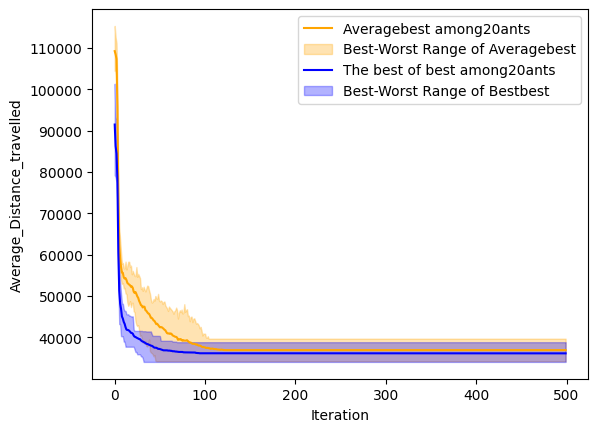

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =100, evaporation_probability = 0.95
best_max: 34285, avg_max: 37531.9, best_iteration: 500.0, sd: 1565.924610002195


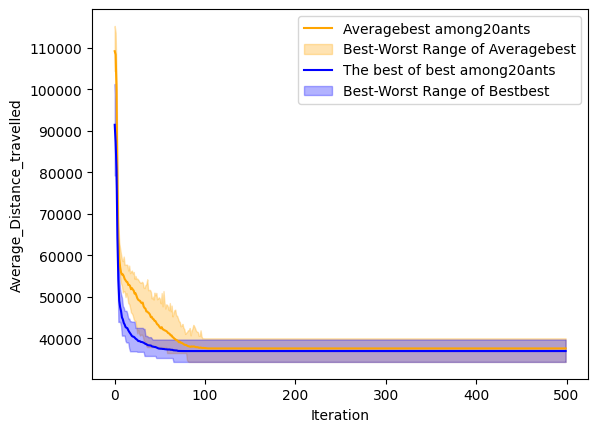

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1000, evaporation_probability = 0.95
best_max: 34858, avg_max: 37186.0, best_iteration: 500.0, sd: 1133.5020256290957


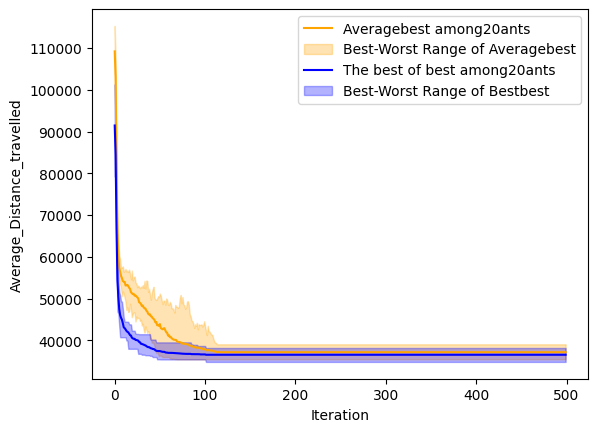

In [ ]:
third_data = readfile("/people.sc.fsu.edu_~jburkardt_datasets_tsp_att48_d.txt")
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1,1,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 10,1,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 100,1,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1000,1,1, 'orange', 'blue',33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1,.95,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 10,.95,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 100,.95,1, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1000,.95,1, 'orange', 'blue',33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1,1,.95, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 10,1,.95, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 100,1,.95, 'orange', 'blue', 33523)
plotcborn(20, 500, third_data, 20, 0 , 0.95, 1000,1,.95, 'orange', 'blue',33523)





Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 937, avg_max: 1004.35, best_iteration: 475.55, sd: 36.544529434361955


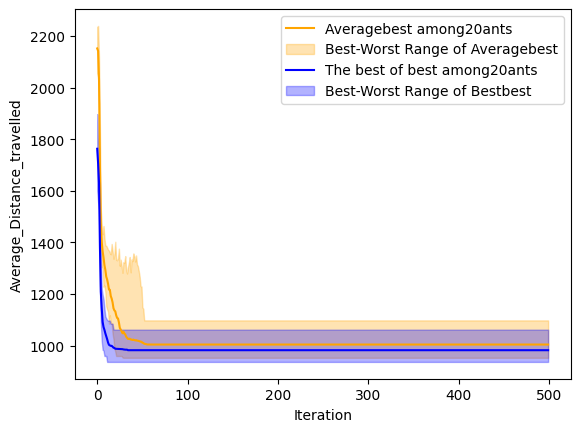

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 937, avg_max: 1007.6, best_iteration: 403.6, sd: 50.51461487321737


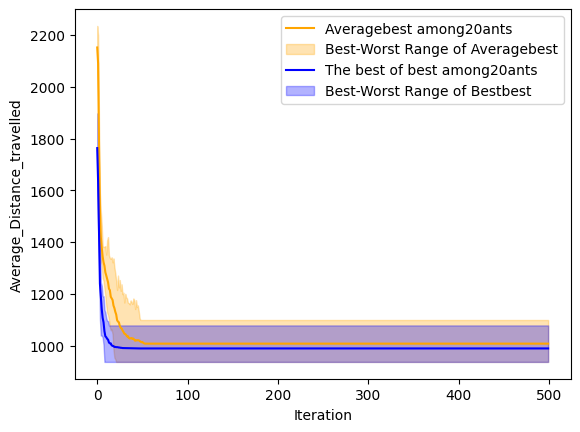

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 941, avg_max: 984.65, best_iteration: 500.0, sd: 32.67910164326012


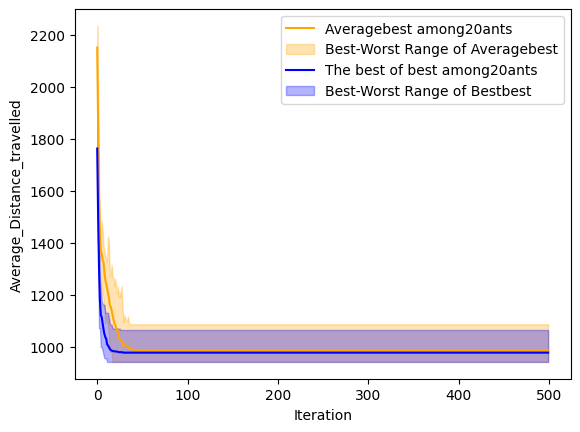

Setting: 20 ants, alpha = 1, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 958, avg_max: 1011.1, best_iteration: 500.0, sd: 38.147773612347905


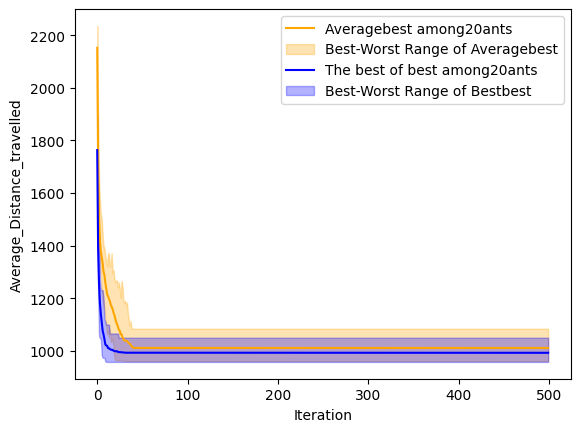

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1, evaporation_probability = 0.95
best_max: 953, avg_max: 1006.65, best_iteration: 500.0, sd: 43.858954555903885


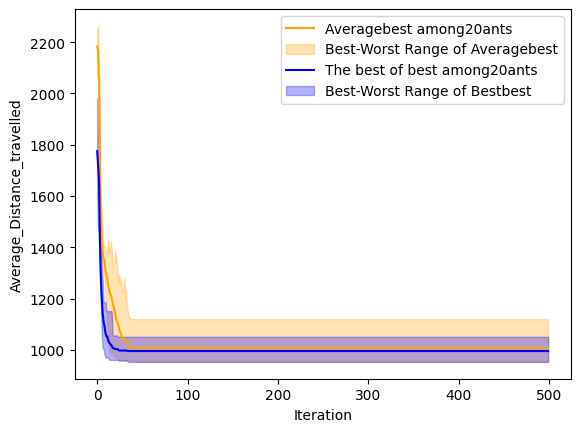

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =10, evaporation_probability = 0.95
best_max: 940, avg_max: 1011.35, best_iteration: 500.0, sd: 43.30950424438886


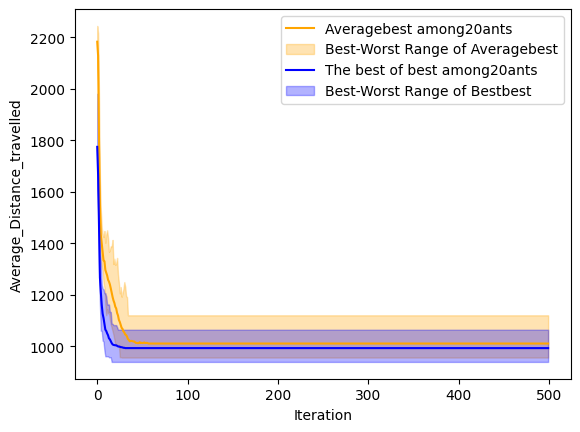

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =100, evaporation_probability = 0.95
best_max: 953, avg_max: 1008.55, best_iteration: 500.0, sd: 40.67389567614202


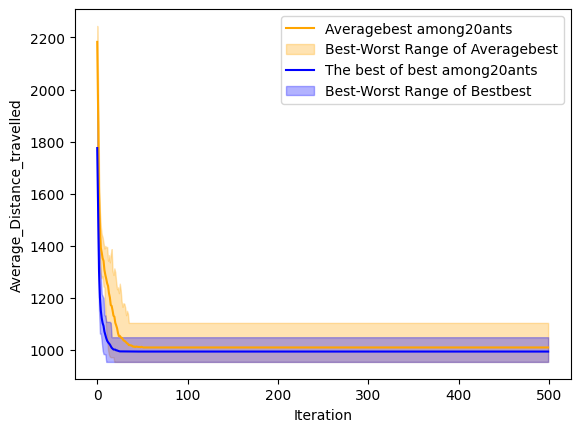

Setting: 20 ants, alpha = 0.95, beta = 1, constant_Q =1000, evaporation_probability = 0.95
best_max: 940, avg_max: 1010.75, best_iteration: 500.0, sd: 55.54123645876477


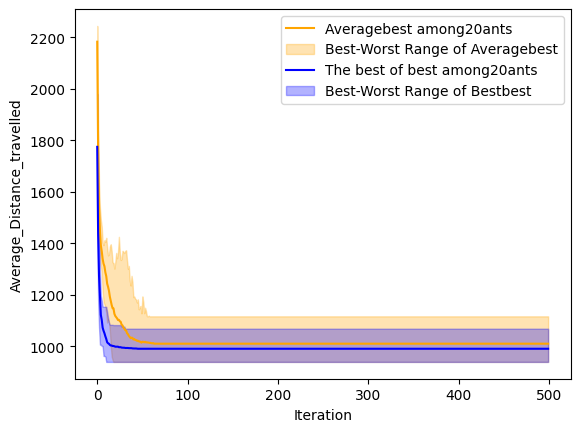

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1, evaporation_probability = 0.95
best_max: 937, avg_max: 998.6, best_iteration: 428.4, sd: 35.01488405325881


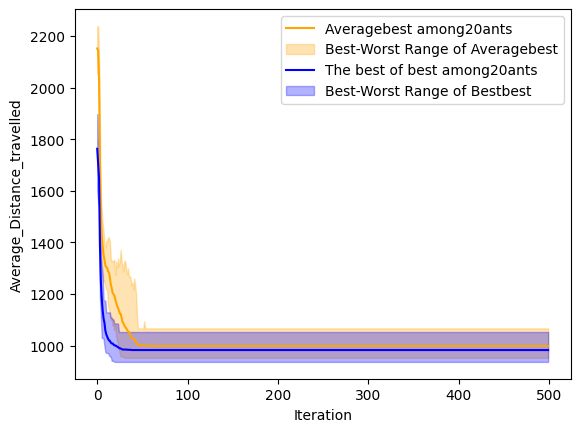

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =10, evaporation_probability = 0.95
best_max: 941, avg_max: 990.3, best_iteration: 500.0, sd: 31.165264064508204


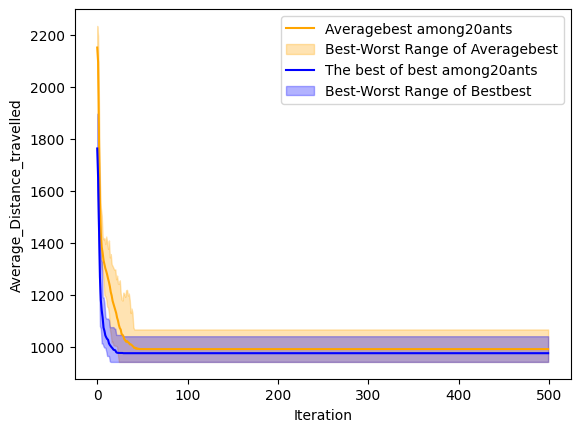

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =100, evaporation_probability = 0.95
best_max: 941, avg_max: 981.95, best_iteration: 500.0, sd: 26.634909818744113


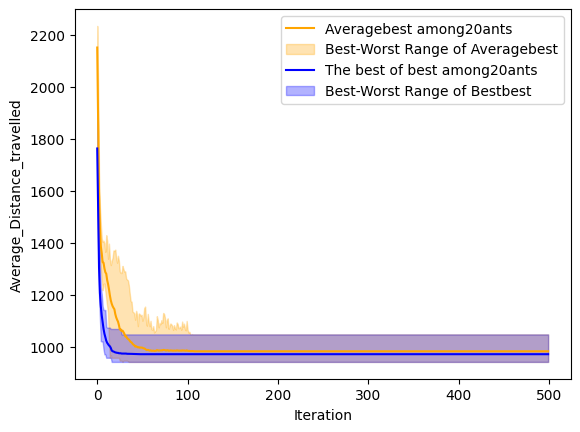

Setting: 20 ants, alpha = 1, beta = 0.95, constant_Q =1000, evaporation_probability = 0.95
best_max: 937, avg_max: 1006.75, best_iteration: 476.1, sd: 45.081067329633484


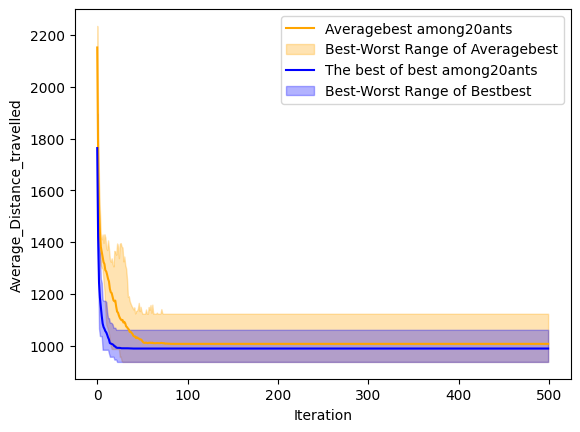

In [9]:
import random
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1,1,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 10,1,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 100,1,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1000,1,1, 'orange', 'blue',937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1,.95,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 10,.95,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 100,.95,1, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1000,.95,1, 'orange', 'blue',937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1,1,.95, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 10,1,.95, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 100,1,.95, 'orange', 'blue', 937)
plotcborn(20, 500, Sec_data_set, 20, 0 , 0.95, 1000,1,.95, 'orange', 'blue',937)

